In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
import glob

def filtering_func_2(freqs, ffts, f1, f2): #passing 2D complex numbers
    filtered_ffts = ffts.copy() # !!!

    ffts_in_range = np.abs(ffts[:, (freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1)])
   
    #average the rows
    fft_in_range = np.mean(ffts_in_range, axis = 0)

    peak = np.max(fft_in_range)

    peak_indices = np.where(fft_in_range == peak)[0]
    print(f"peak_indices: {peak_indices}")

    peak_f = freqs[(freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1)][peak_indices]
    print(f"peak_f: {peak_f}")

    ffts_in_range[:, peak_indices] = np.nan
    range_avgs = np.nanmean(ffts_in_range, axis = 1) #excluding the point you are filtering

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    filtered_ffts[:, np.isin(freqs, peak_f)] = range_avgs[:, np.newaxis] + 0j #!!!
    return filtered_ffts, range_avgs, peak_f #returning a 2d complex array

In [2]:
hour = '15.42'
day = '08082024'

In [3]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        print(df)
        if i == 0:
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values #If ‘coerce’, then invalid parsing will be set as NaN.
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values #If ‘coerce’, then invalid parsing will be set as NaN.
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)

              Time    Channel D
0             (us)         (mV)
1       0.00000000  -1.96850400
2       0.00080000  -1.57480300
3       0.00160000  -1.18110200
4       0.00240000  -0.78740150
...            ...          ...
62500  49.99920067   0.00000000
62501  50.00000067   0.39370070
62502  50.00080067  -0.39370070
62503  50.00160067  -1.18110200
62504  50.00240067  -1.18110200

[62505 rows x 2 columns]
              Time    Channel D
0             (us)         (mV)
1       0.00000000   1.57480300
2       0.00080000   0.78740150
3       0.00160000   0.00000000
4       0.00240000   0.00000000
...            ...          ...
62500  49.99920067   1.57480300
62501  50.00000067   0.78740150
62502  50.00080067  -0.39370070
62503  50.00160067  -2.75590500
62504  50.00240067  -4.72440900

[62505 rows x 2 columns]
              Time    Channel D
0             (us)         (mV)
1       0.00000000  -0.39370070
2       0.00080000  -0.39370070
3       0.00160000   0.39370070
4       0.00240000  

In [4]:
N = len(times)
print(f"len(times): {N}")

len(times): 62504


## FFT

In [5]:
span = times[-1]
print(f"span: {span}") 
step = span / N
f_s = 1 / step
print(f"f_s = {f_s}")

freqs = fft.fftfreq(N, 1/f_s) #window lenght, sample spacing
print(f'last freq: {freqs[-1]}') #this should be the half of f_s.
print(f"len(freqs): {len(freqs)}")
print(freqs)

span: 50.00240067
f_s = 1250.0199822905824
last freq: -0.019999039778103522
len(freqs): 62504
[ 0.          0.01999904  0.03999808 ... -0.05999712 -0.03999808
 -0.01999904]


In [6]:
all_magnitudes = fft.fft(all_amplitudes, axis = 1) 
all_phases = np.angle(all_magnitudes) #prova a invertire: prima fai la media poi fai l'angolo

In [7]:
avg_fft = np.mean(np.abs(all_magnitudes), axis = 0) 
n = np.max(avg_fft)

avg_phases = np.mean(all_phases, axis = 0)

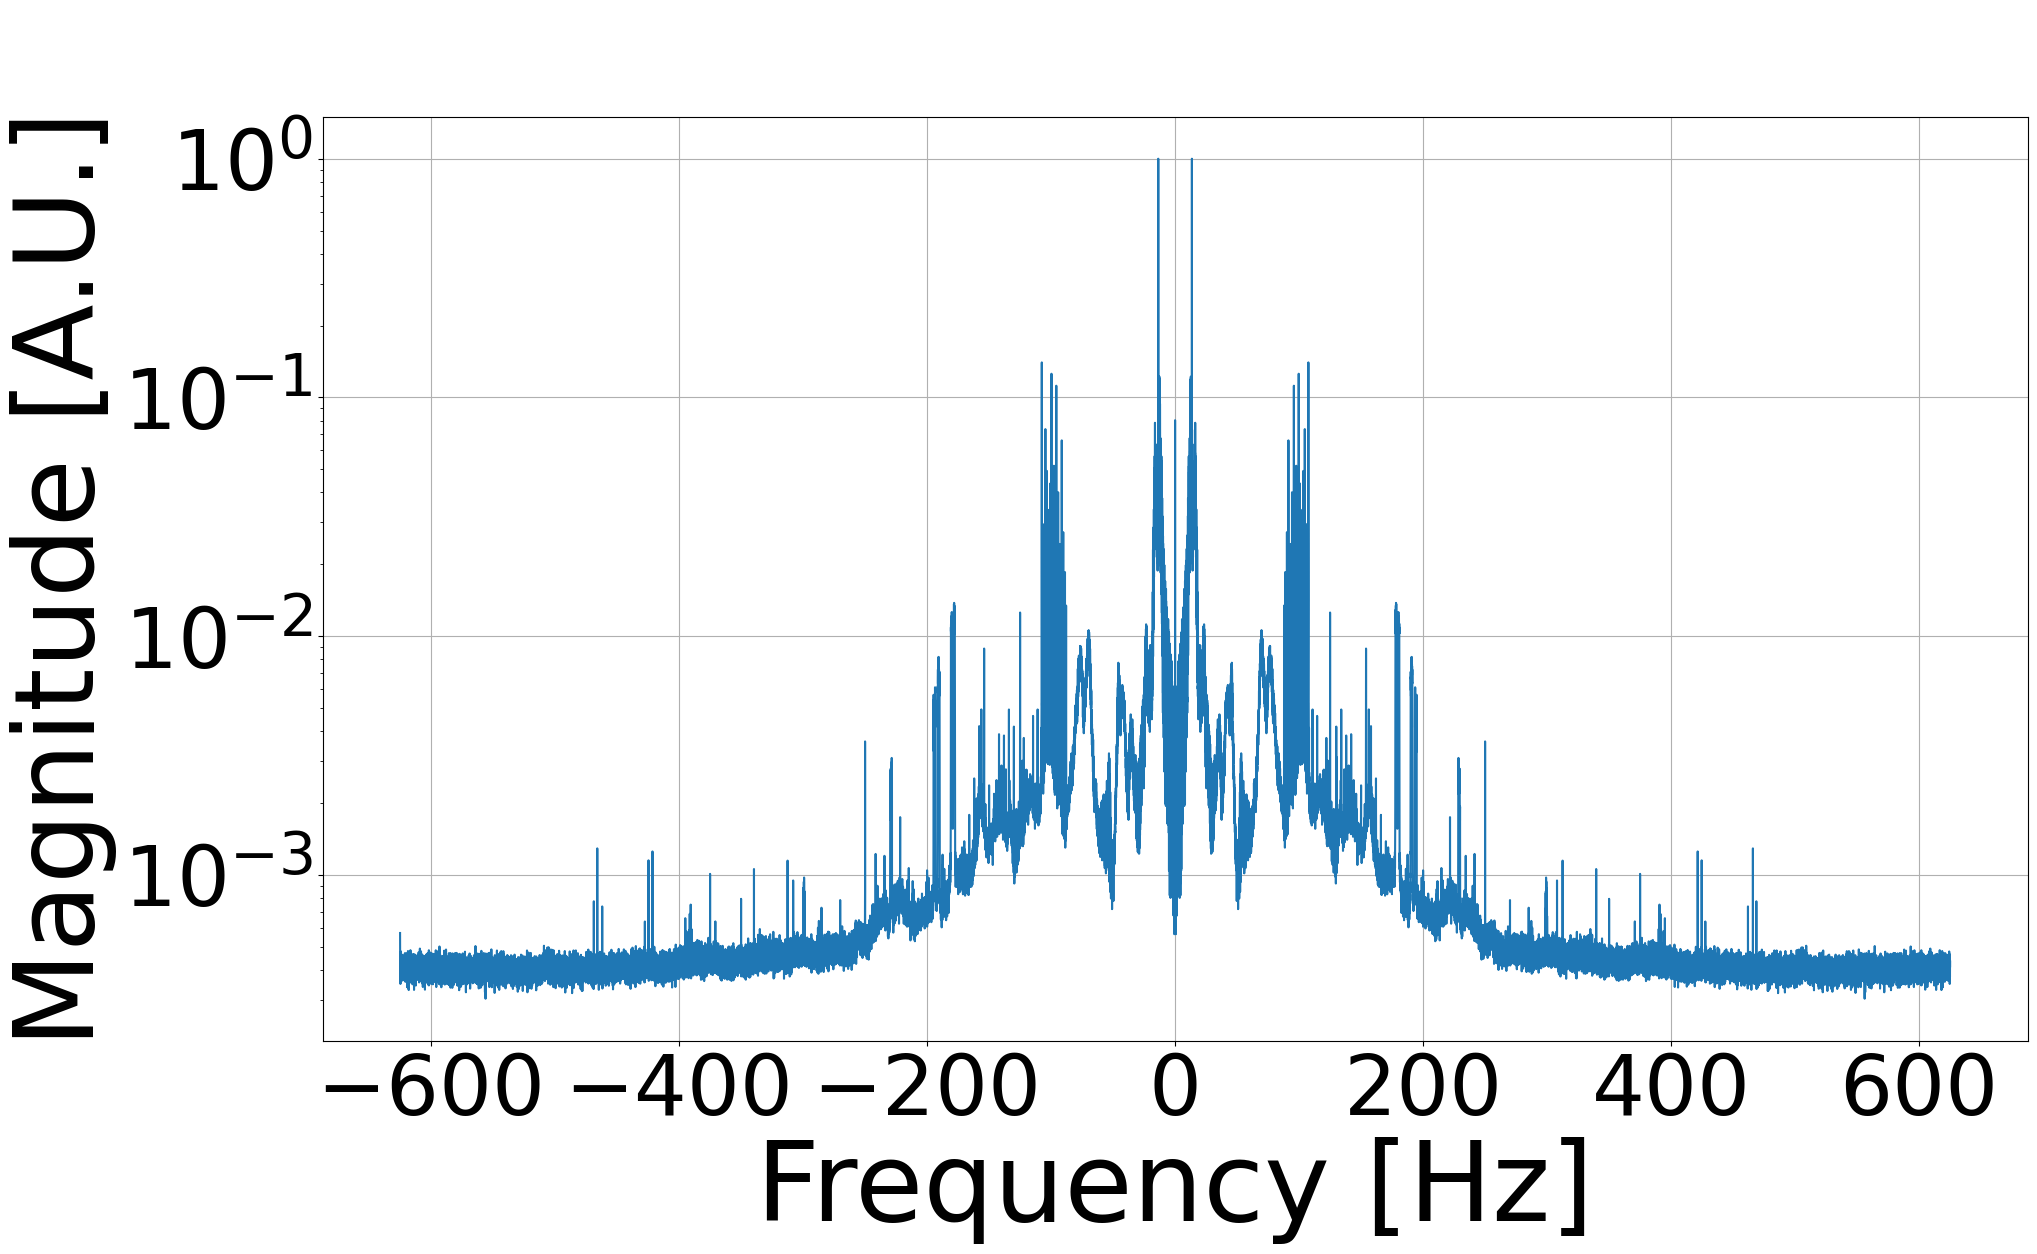

In [8]:
freqs_shifted = fft.fftshift(freqs)
avg_fft_shifted = fft.fftshift(avg_fft)

plt.figure(figsize=(22, 12))
plt.plot(freqs_shifted, np.abs(avg_fft_shifted)/n)

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [Hz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.semilogy()
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [9]:
if (N%2 == 0):
    pos_freqs = freqs[:round((N/2))]
    pos_avg_fft = avg_fft[:round((N/2))]
    pos_avg_phases = avg_phases[:round((N/2))]
else:
    pos_freqs = freqs[:round((N-1)/2 + 1)]
    pos_avg_fft = avg_fft[:round((N-1)/2 + 1)]
    pos_avg_phases = avg_phases[:round((N-1)/2 + 1)]


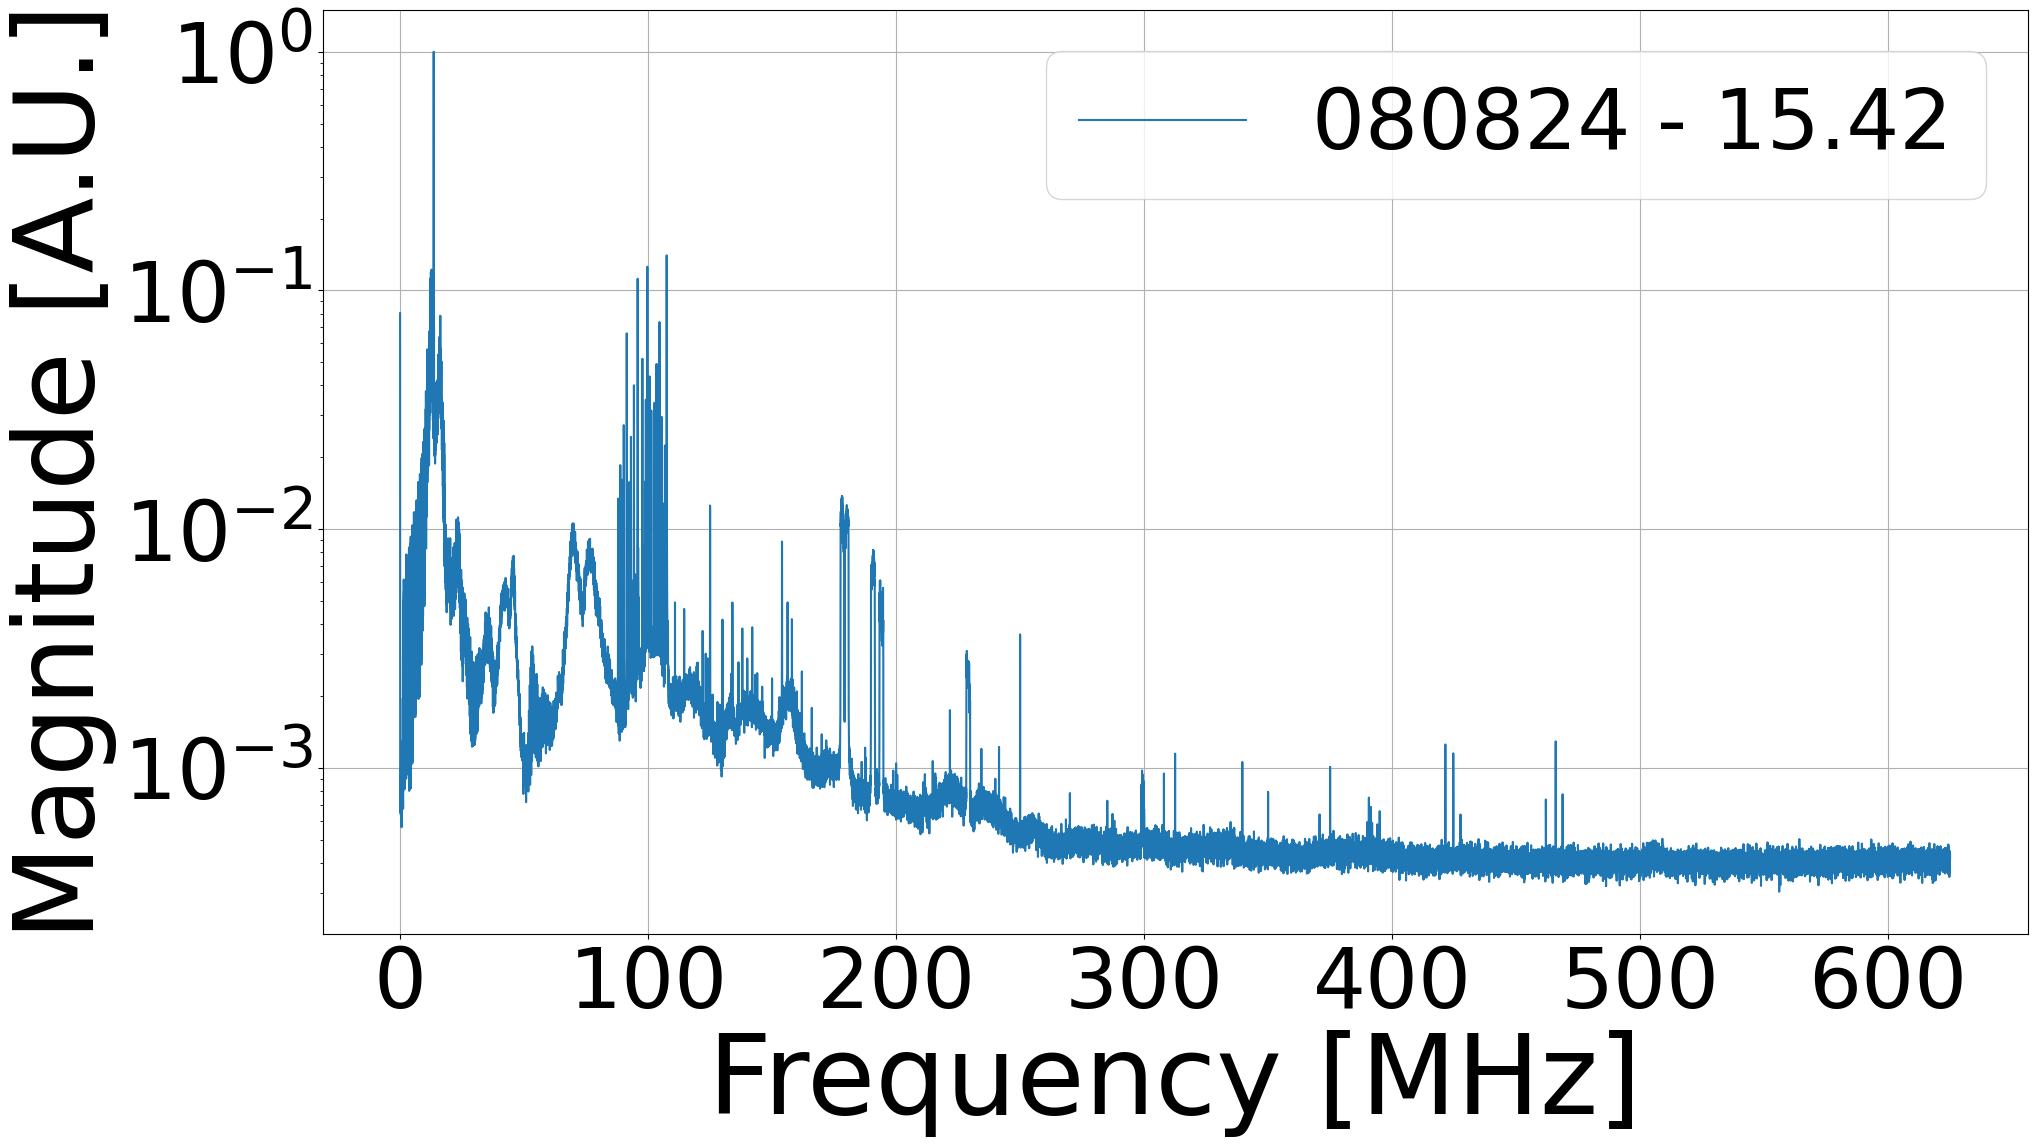

In [10]:
plt.figure(figsize=(22, 12))
plt.plot(pos_freqs, pos_avg_fft/n, label = '080824 - 15.42')

plt.title('', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.semilogy()
plt.grid(True)
plt.legend(loc = 'best', fontsize = 60)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

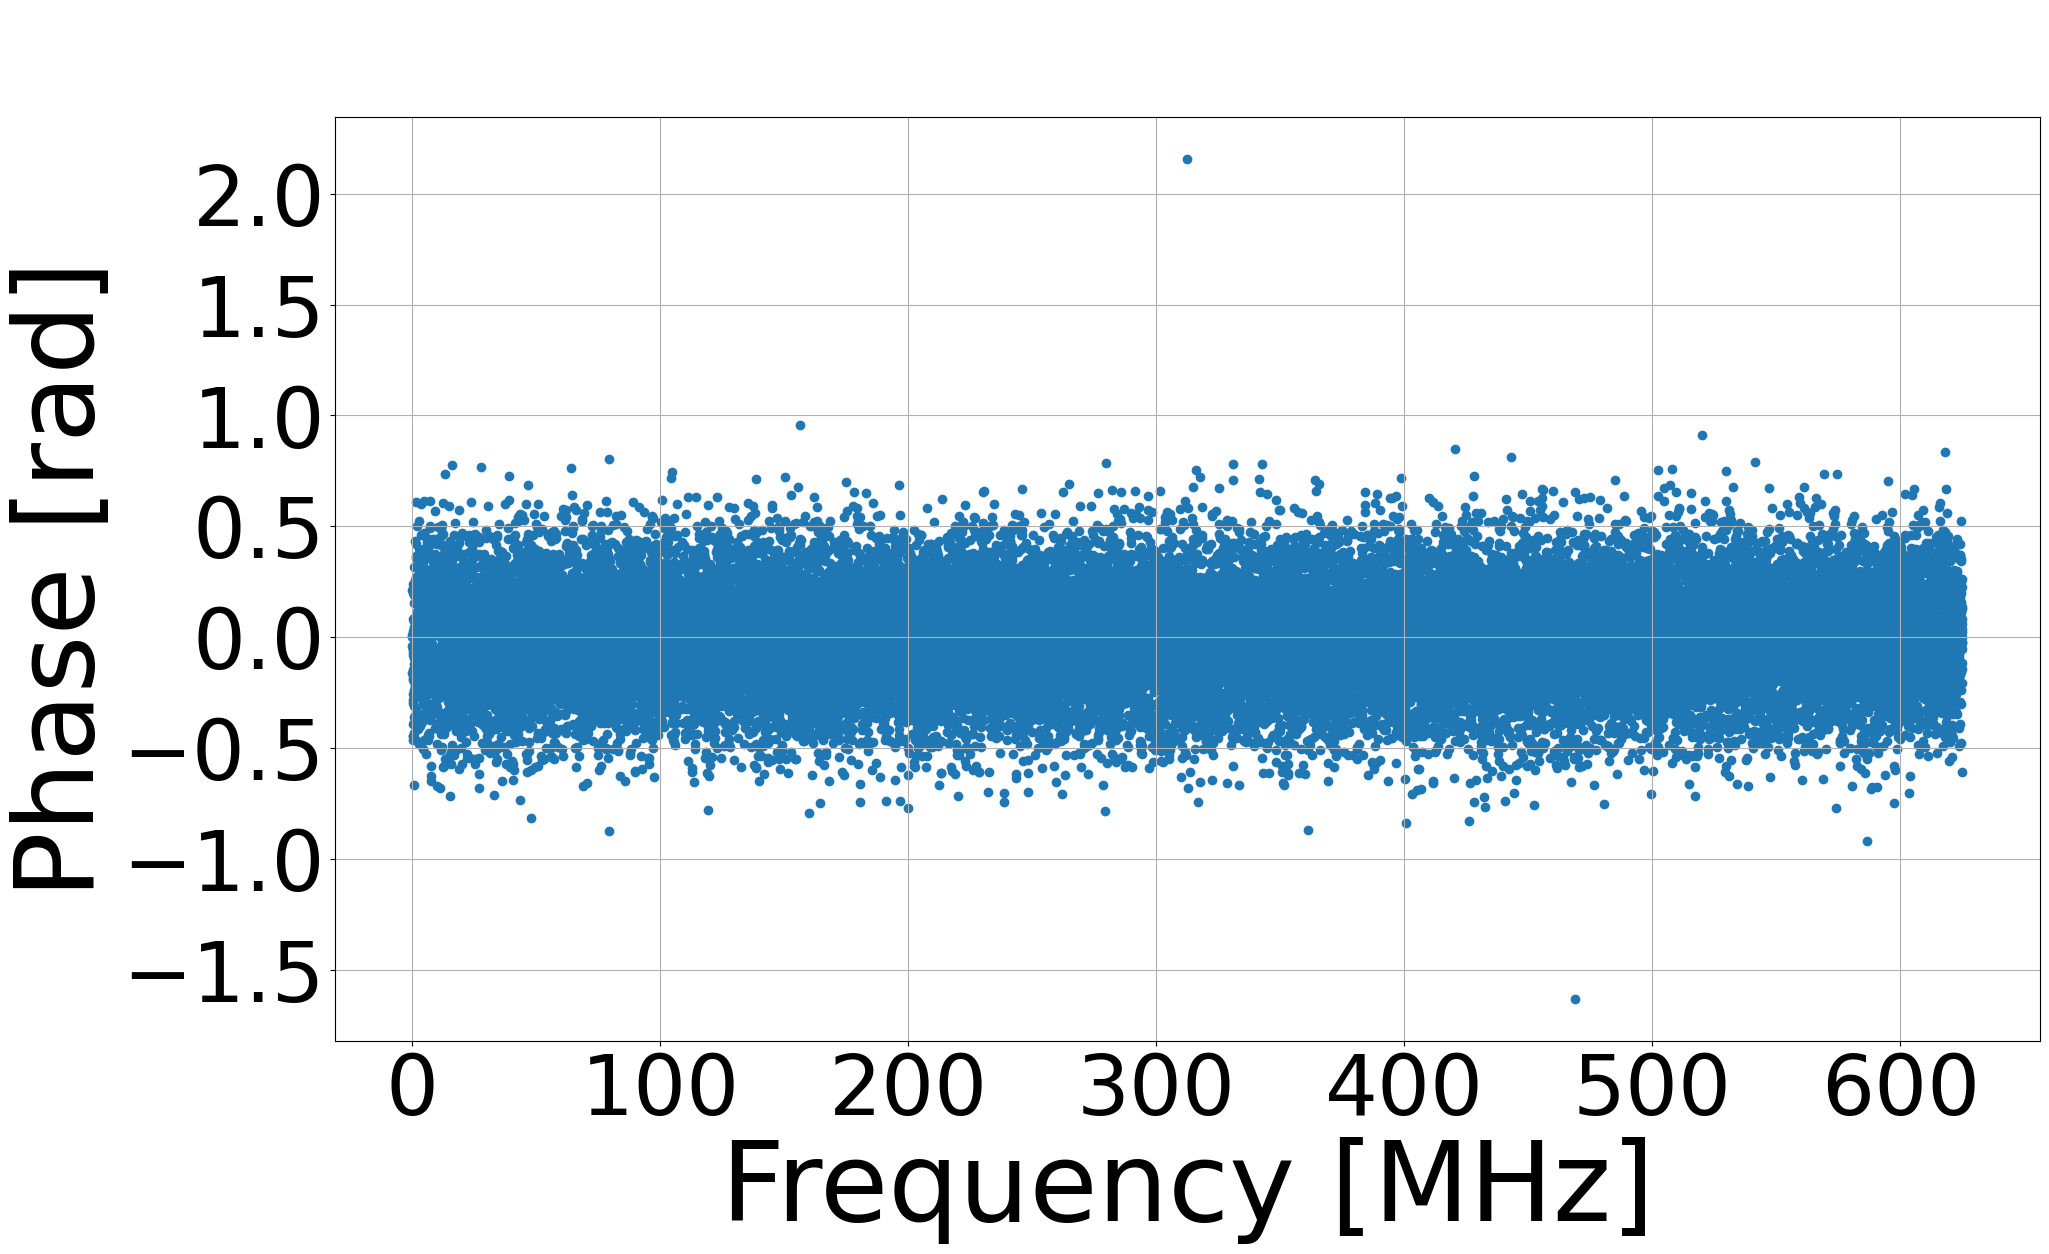

In [11]:
plt.figure(figsize=(22, 12))
plt.scatter(pos_freqs, pos_avg_phases)

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Phase [rad]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [12]:
f1 = 13
f2 = 14

In [13]:
print(f"positive peak phase: {pos_freqs[(pos_freqs >= f1) & (pos_freqs <= f2)][np.argmax(pos_avg_fft[(pos_freqs <= f2) & (pos_freqs >= f1)])]} MHz")
print(f"positive peak phase: {pos_avg_phases[(pos_freqs >= f1) & (pos_freqs <= f2)][np.argmax(pos_avg_fft[(pos_freqs <= f2) & (pos_freqs >= f1)])]*180/np.pi} deg")

positive peak phase: 13.559348969554188 MHz
positive peak phase: 21.62065859970982 deg


## Filtering

In [14]:
filtered_ffts, range_avgs, peak_f = filtering_func_2(freqs, all_magnitudes, f1, f2)

peak_indices: [27 72]
peak_f: [ 13.55934897 -13.55934897]
sum: 2


## IFFT

In [15]:
#times_ifft = np.arange(N) / f_s #SAME as times, just checking
filtered_wfs = fft.ifft(filtered_ffts, axis = 1) 
avg_filtered_wf = np.mean(filtered_wfs.real, axis = 0)

## Compare to reconstructed waveform

In [16]:
reconstructed_wfs = fft.ifft(all_magnitudes, axis = 1)
avg_reconstructed_wf = np.mean(reconstructed_wfs.real, axis = 0)

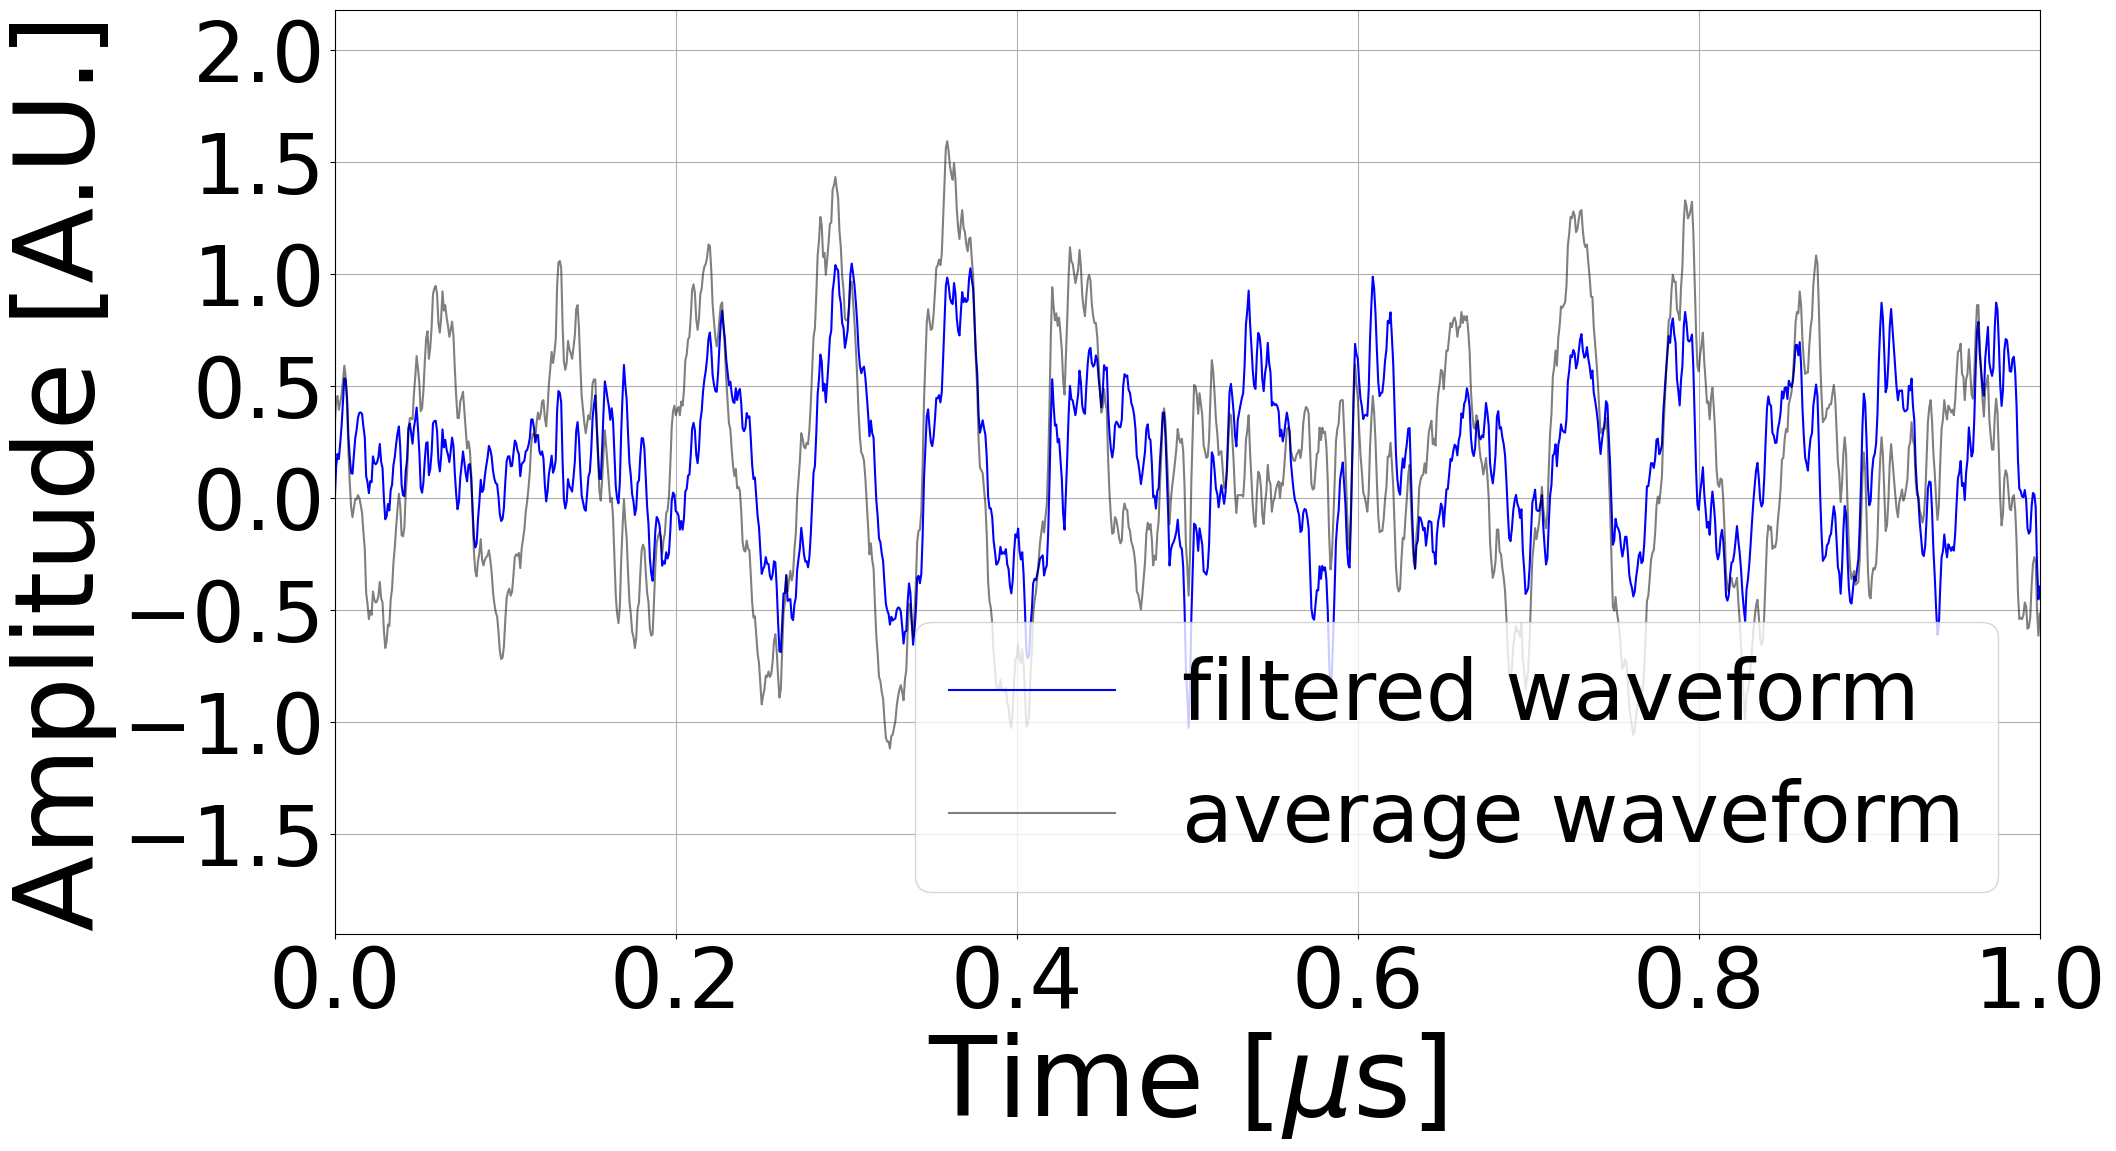

In [29]:
plt.figure(figsize = (22, 12))
plt.plot(times, avg_filtered_wf, label = 'filtered waveform', color = 'blue')
plt.plot(times, avg_reconstructed_wf, label = 'average waveform', color = 'k', alpha = 0.5)

plt.title('', fontsize = 80)
plt.xlabel(r'Time [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 60)

#plt.savefig("../Results/080824_15.42/method1_filtered_wf_test3.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/method1_filtered_wf_test3.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [18]:
avg_noise_wf = avg_reconstructed_wf - avg_filtered_wf 

In [19]:
A = max(avg_noise_wf)
phi = pos_avg_phases[pos_freqs == peak_f[0]]
f = peak_f[0]
coswave = A*np.cos(f * 2*np.pi*times + phi)

[-0.2431775  -0.26266502 -0.2809328  ... -0.16964349 -0.18943035
 -0.20833753]


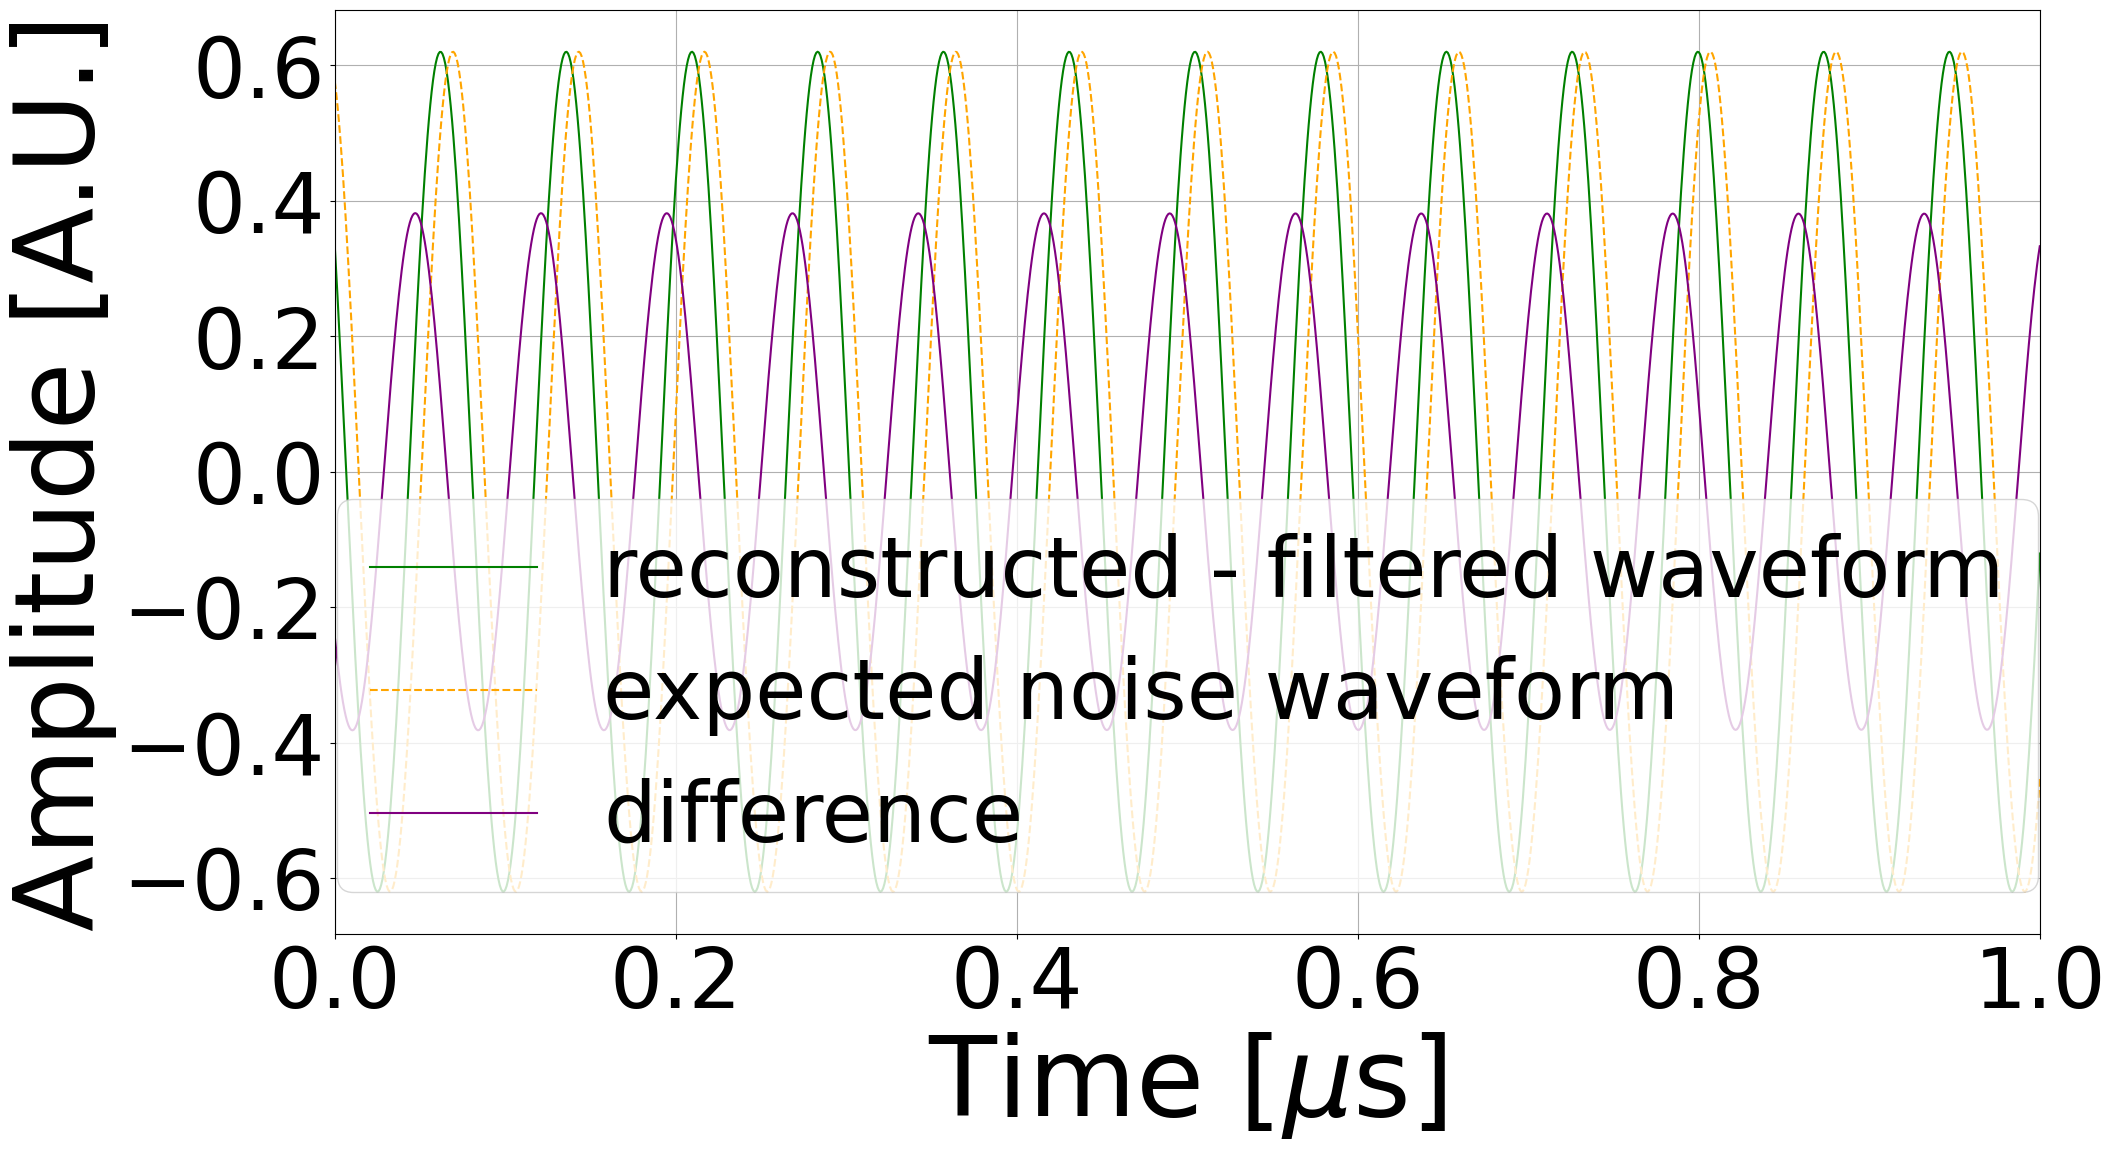

In [30]:
plt.figure(figsize = (22, 12))
plt.plot(times, avg_noise_wf, label = 'reconstructed - filtered waveform', color = 'green')
plt.plot(times, coswave, label = 'expected noise waveform', color = 'orange', linestyle = '--')
plt.plot(times, avg_noise_wf - coswave, label = 'difference', color = 'purple')
print(avg_noise_wf.real - coswave)


plt.title('', fontsize = 80)
plt.xlabel(r'Time [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'lower center', fontsize = 60)

#plt.savefig("../Results/080824_15.42/method1_noise_wf_test3.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/method1_noise_wf_test3.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [21]:
print(np.arccos((avg_noise_wf)[times == 0]/A)*180/np.pi)
print(np.arccos((coswave)[times == 0]/A)*180/np.pi)

[57.48531114]
[21.6206586]


# Make sure reconstructed waveform and original waveform are the same

In [22]:
avg_wf = np.mean(all_amplitudes, axis = 0)

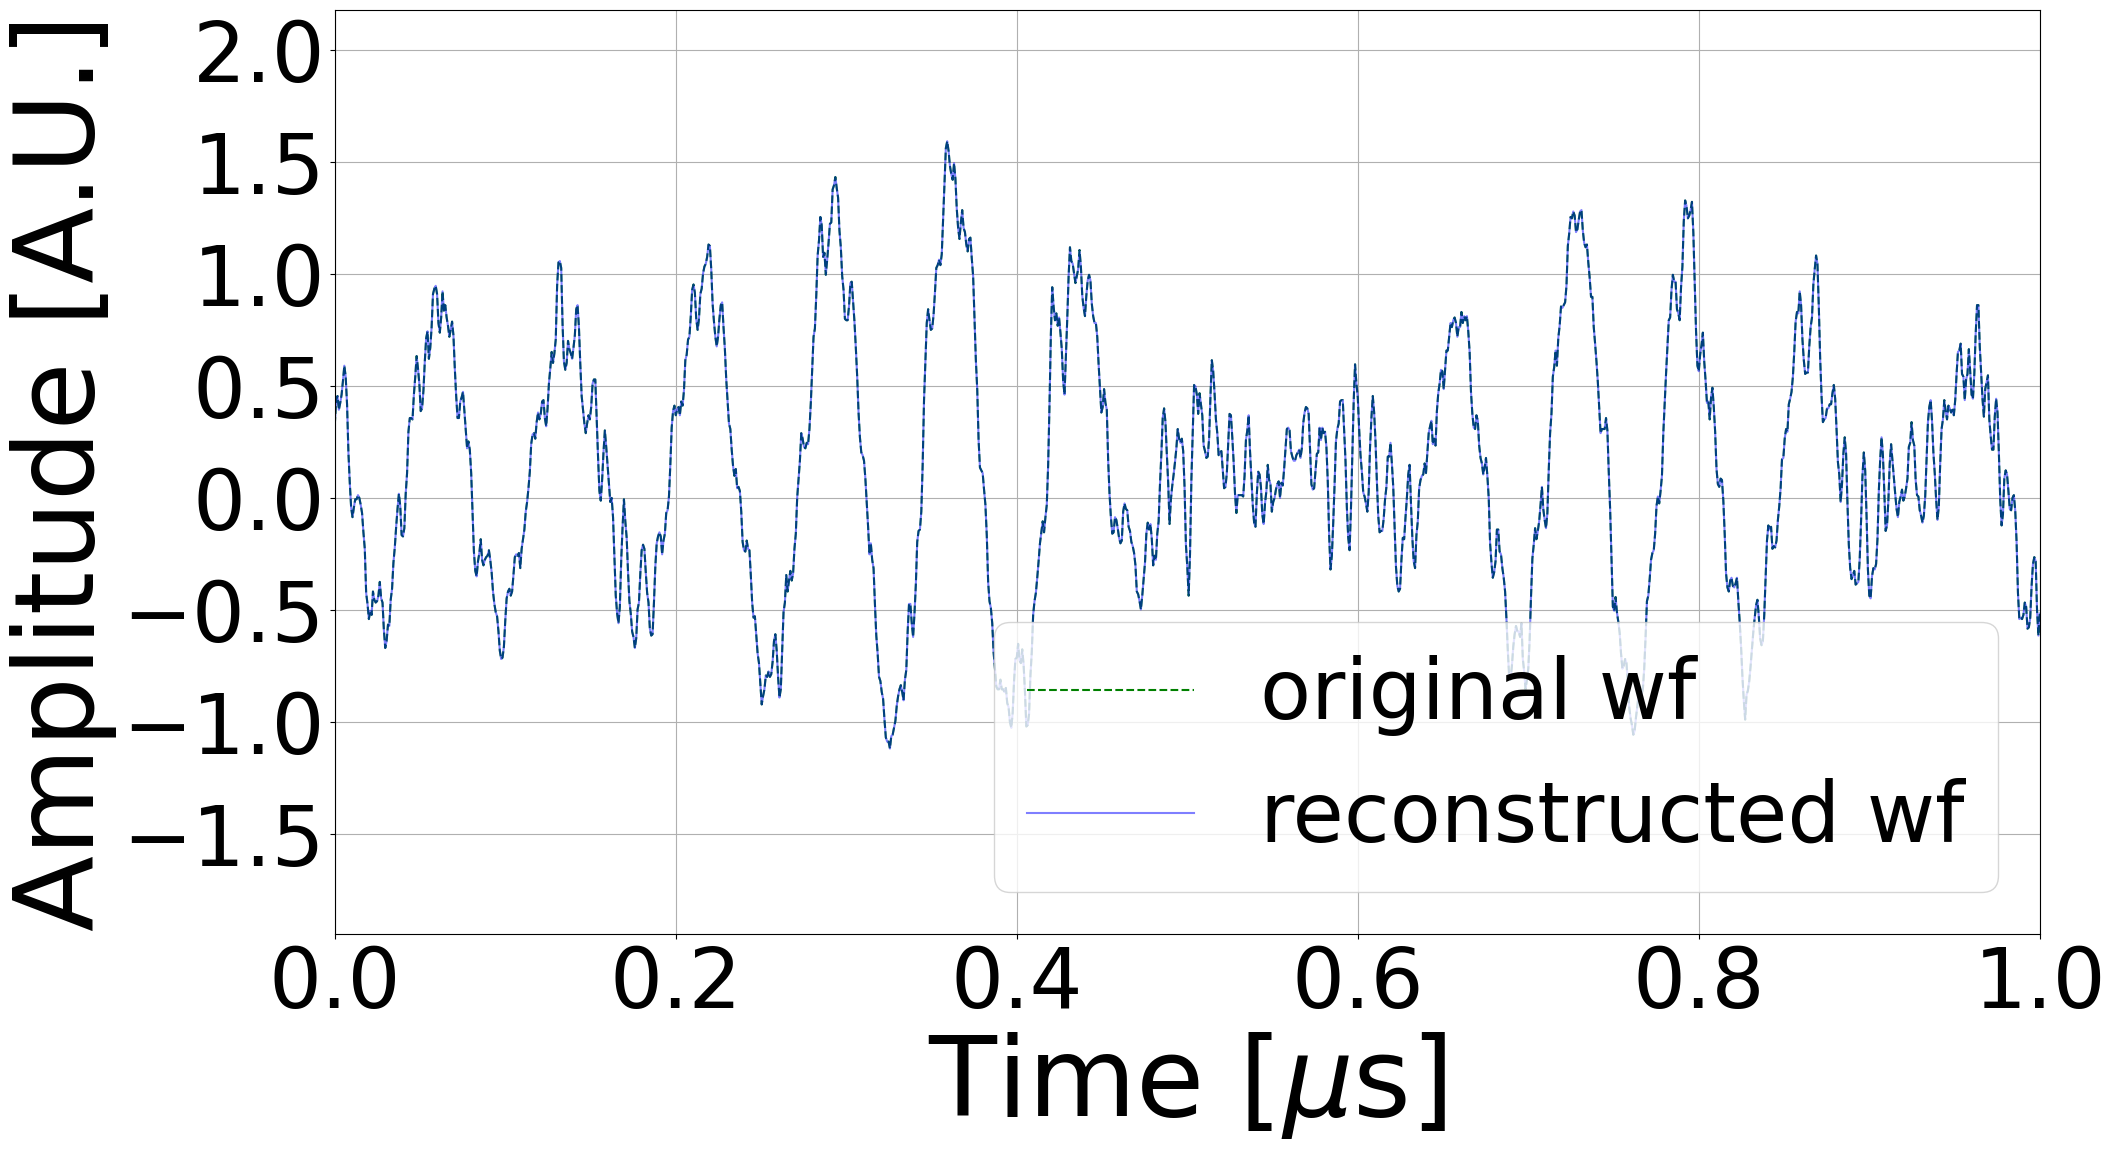

In [23]:
plt.figure(figsize = (22, 12))
plt.plot(times, avg_wf, label = 'original wf', color = 'green', linestyle = '--')
plt.plot(times, avg_reconstructed_wf, label = 'reconstructed wf', color = 'blue', alpha = 0.5)

plt.title('', fontsize = 80)
plt.xlabel(r'Time [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 60)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

# Plot reconstructed FFT

In [24]:
avg_reconstructed_filtered_fft = fft.fft(avg_filtered_wf)
avg_reconstructed_fft = fft.fft(avg_wf)
n2 = max(np.abs(avg_reconstructed_fft))

In [25]:
range_avg = np.mean(np.abs(range_avgs))

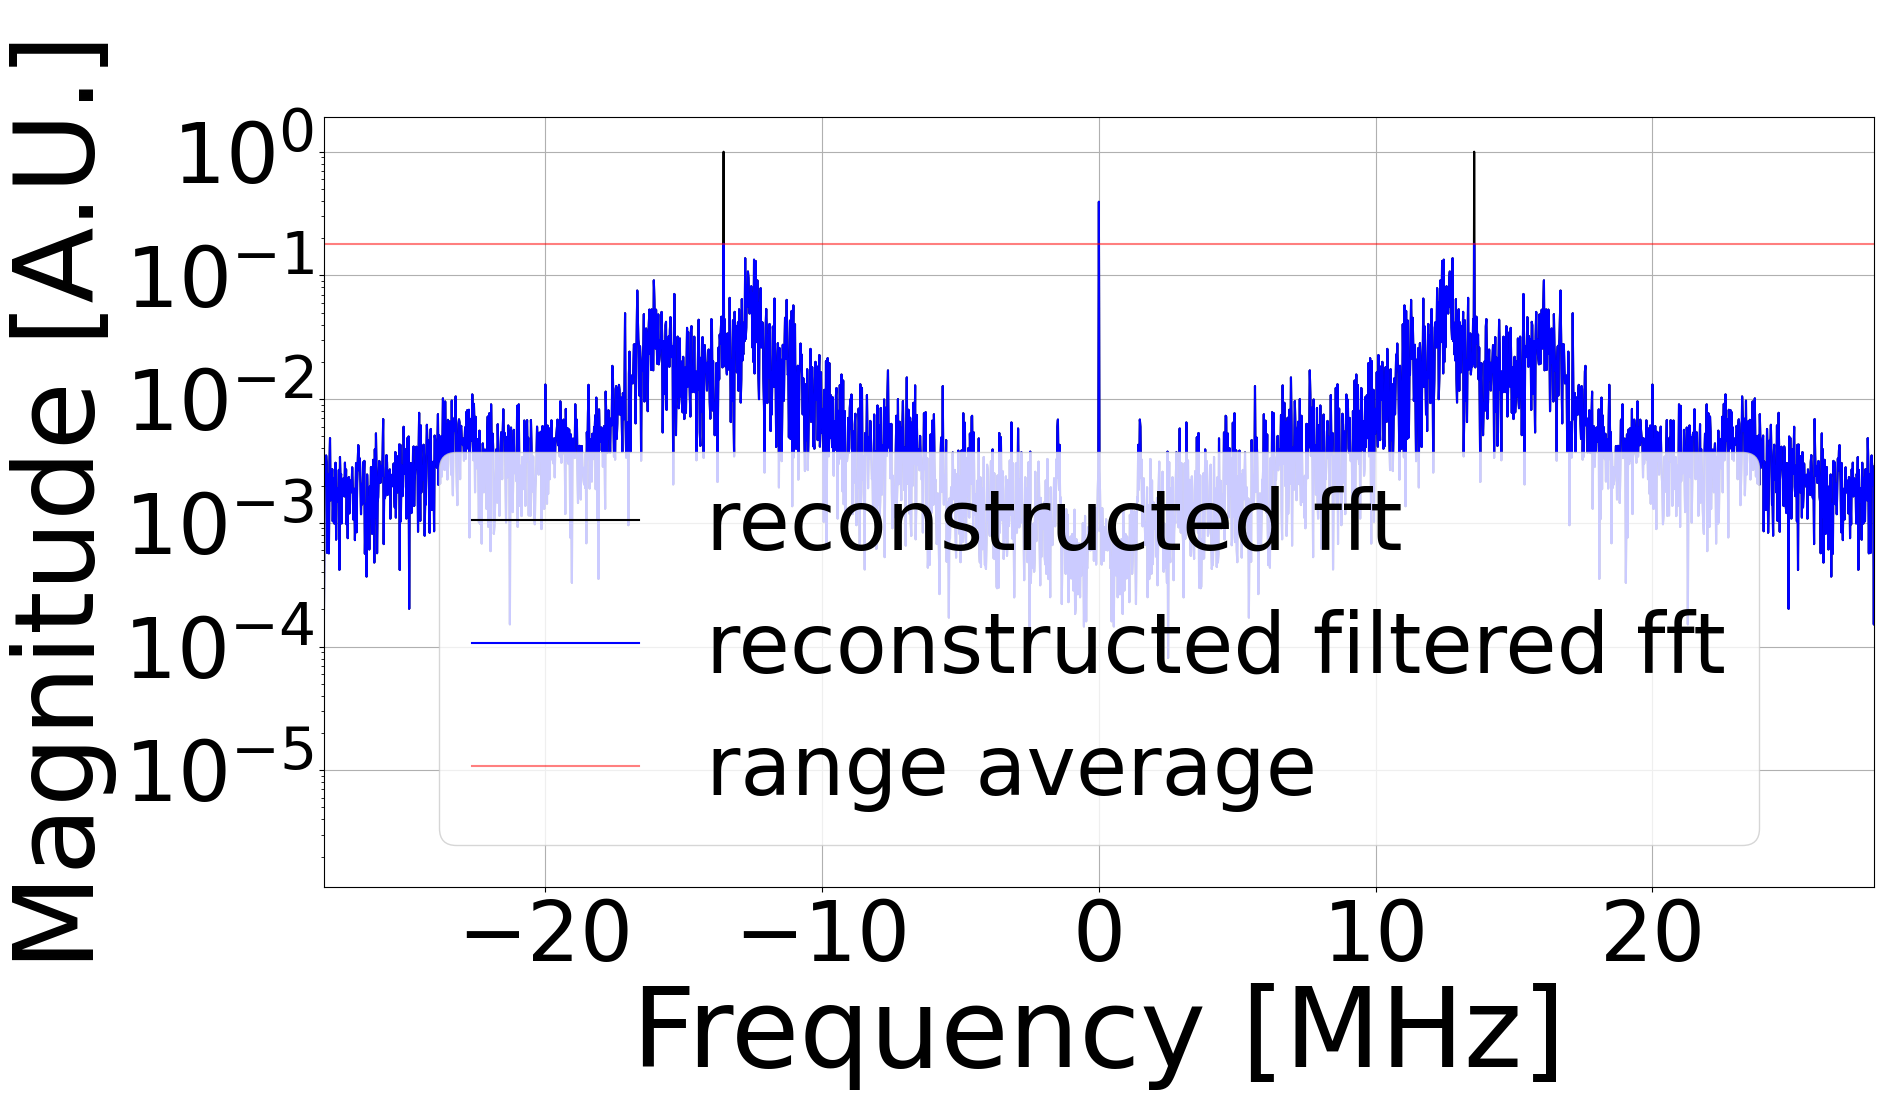

In [26]:
avg_reconstructed_filtered_fft_shifted = fft.fftshift(avg_reconstructed_filtered_fft) 
avg_reconstructed_fft_shifted = fft.fftshift(avg_reconstructed_fft)

plt.figure(figsize=(20, 10))
plt.plot(freqs_shifted, np.abs(avg_reconstructed_fft_shifted)/n2, color = 'k', label = 'reconstructed fft')
plt.plot(freqs_shifted, np.abs(avg_reconstructed_filtered_fft_shifted)/n2, color = 'blue', label = 'reconstructed filtered fft')
plt.axhline(range_avg/n2, color = 'red', alpha = 0.5, label = 'range average')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(-f2*2, f2*2)
plt.legend(loc = 'best', fontsize = 60)
plt.semilogy()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [27]:
if (N%2 == 0):
    pos_avg_reconstructed_filtered_fft = avg_reconstructed_filtered_fft[:round((N/2))]
    pos_avg_reconstructed_fft = avg_reconstructed_fft[:round((N/2))]

else:
    pos_avg_reconstructed_filtered_fft = avg_reconstructed_filtered_fft[:round((N-1)/2 + 1)]
    pos_avg_reconstructed_fft = avg_reconstructed_fft[:round((N/2))]


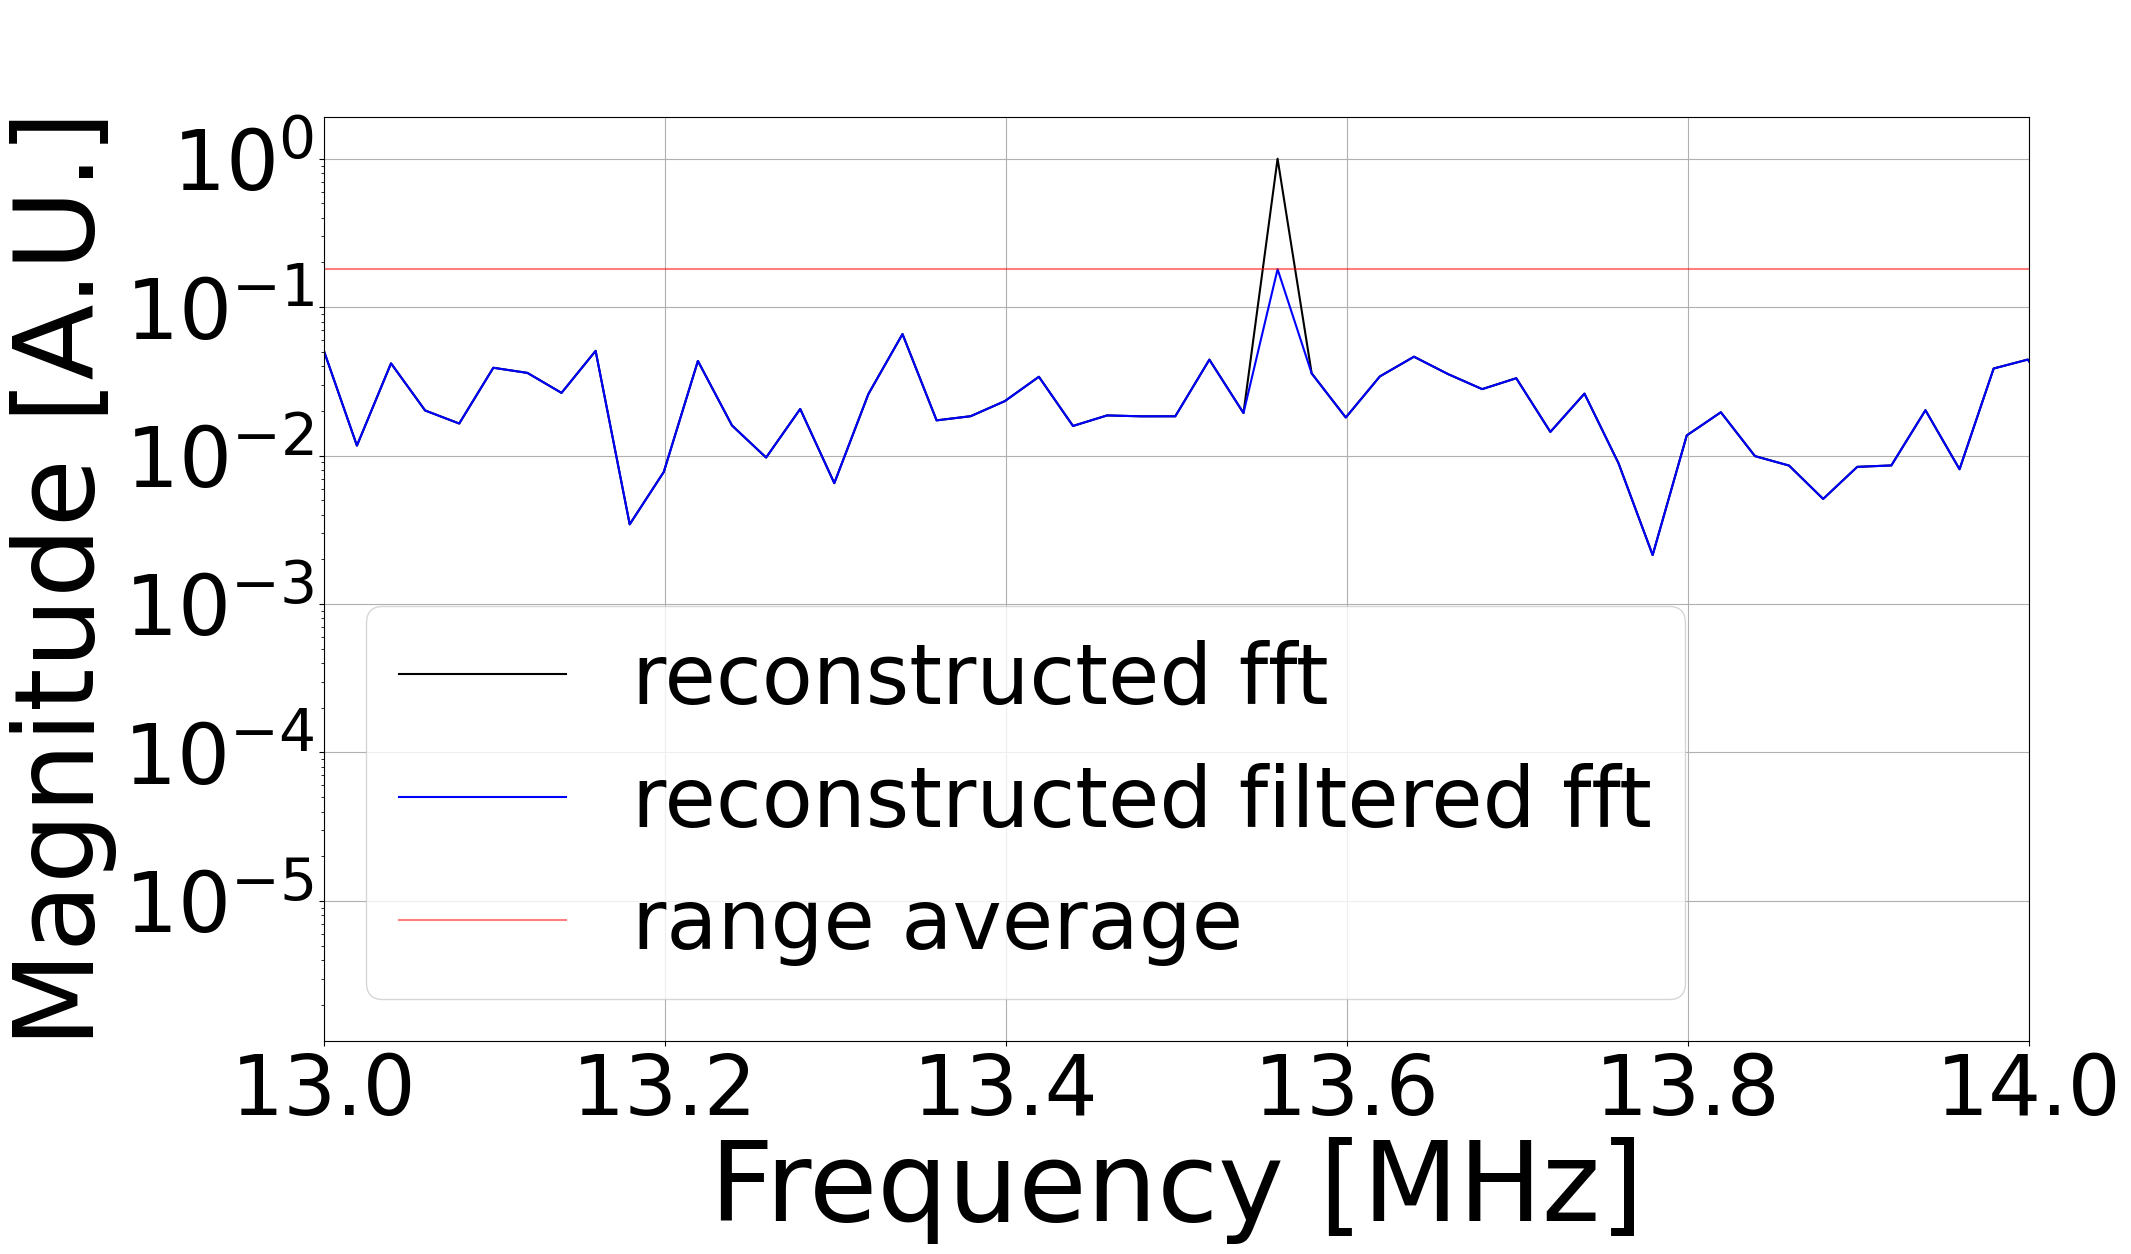

In [28]:
plt.figure(figsize = (22, 12))
plt.plot(pos_freqs, np.abs(pos_avg_reconstructed_fft)/n2, color = 'k', label = 'reconstructed fft')
plt.plot(pos_freqs, np.abs(pos_avg_reconstructed_filtered_fft)/n2, color = 'blue', label = 'reconstructed filtered fft')
plt.axhline(range_avg/n2, color = 'red', alpha = 0.5, label = 'range average')

plt.title(' ', fontsize = 80)
plt.xlabel(r'Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.semilogy()

plt.xlim(f1, f2)
plt.legend(loc = 'best', fontsize = 60)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/method1_reconstructed_filtered_fft_test3.pdf", format = "pdf", bbox_inches="tight")
plt.show()